In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from torchvision import transforms
import numpy as np

# Set random seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((256, 256))(mask)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset paths
image_dir = "/content/drive/MyDrive/Kvasir-SEG/images"
mask_dir = "/content/drive/MyDrive/Kvasir-SEG/masks"

images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

image_paths = [os.path.join(image_dir, img) for img in images]
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

# Split into train (85%), validation (10%), and test (5%)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(image_paths, mask_paths, test_size=0.15, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.3333, random_state=42)

# Initialize datasets
train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = SegmentationDataset(val_imgs, val_masks, transform=val_test_transform)
test_dataset = SegmentationDataset(test_imgs, test_masks, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(f_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()

        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)
        self.center = ConvBlock(512, 1024)

        self.att4 = AttentionBlock(512, 512, 256)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = ConvBlock(1024, 512)

        self.att3 = AttentionBlock(256, 256, 128)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = ConvBlock(512, 256)

        self.att2 = AttentionBlock(128, 128, 64)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ConvBlock(256, 128)

        self.att1 = AttentionBlock(64, 64, 32)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        center = self.center(self.pool(e4))

        d4 = self.upconv4(center)
        e4 = self.att4(d4, e4)
        d4 = self.decoder4(torch.cat((d4, e4), dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.decoder3(torch.cat((d3, e3), dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.decoder2(torch.cat((d2, e2), dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.decoder1(torch.cat((d1, e1), dim=1))

        output = self.final_conv(d1)
        return output

# Example usage
if __name__ == "__main__":
    model = AttentionUNet(in_channels=1, out_channels=1)
    x = torch.randn(1, 1, 256, 256)  # Example input
    y = model(x)
    print(y.shape)  # Expected output shape: (1, 1, 256, 256)


torch.Size([1, 1, 256, 256])


In [4]:
import warnings
warnings.filterwarnings("ignore")

Loaded best model with val_loss: 0.6245 | Resuming from epoch 46
Epoch 46/2000 | Train Loss: 0.8326 | Val Loss: 0.6276 | IoU: 0.5336
Epoch 47/2000 | Train Loss: 0.8428 | Val Loss: 0.6325 | IoU: 0.5368
Epoch 48/2000 | Train Loss: 0.8303 | Val Loss: 0.6413 | IoU: 0.5268
Epoch 49/2000 | Train Loss: 0.8244 | Val Loss: 0.5976 | IoU: 0.5610
Saved best model at epoch 49
Epoch 50/2000 | Train Loss: 0.8390 | Val Loss: 0.6611 | IoU: 0.5216


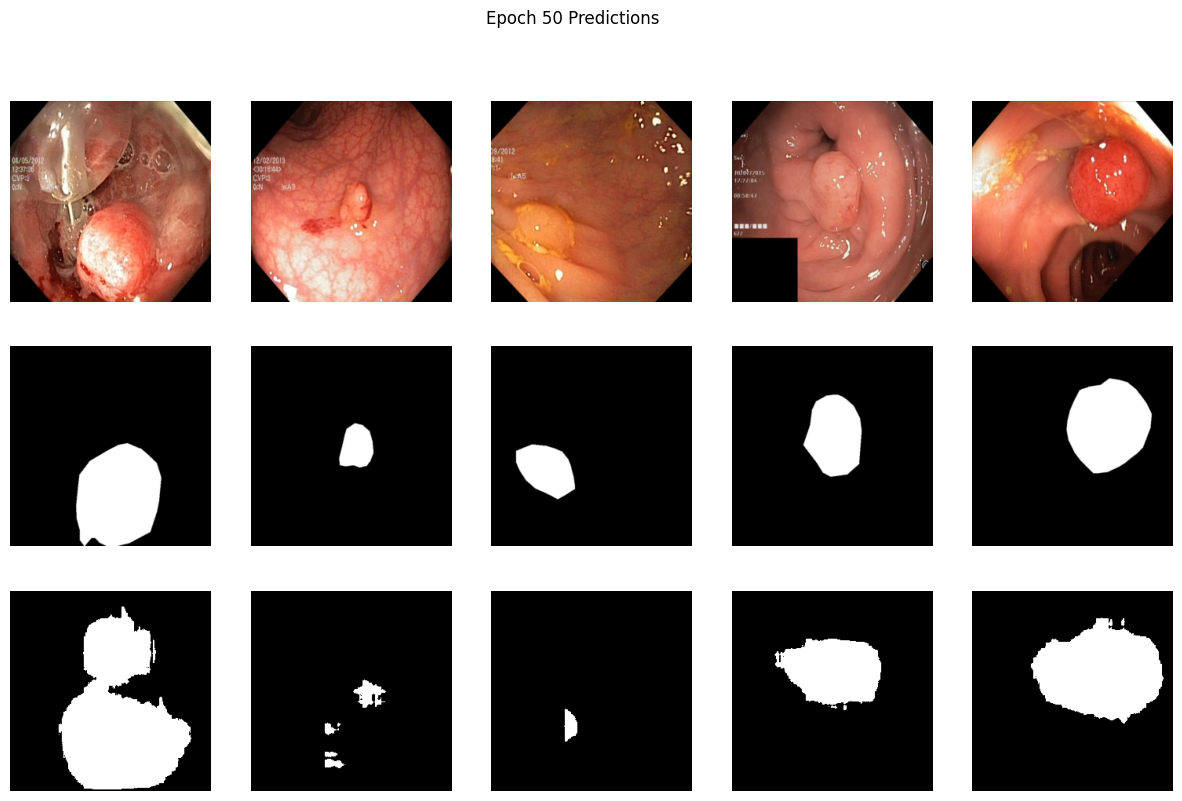

Epoch 51/2000 | Train Loss: 0.8316 | Val Loss: 0.6092 | IoU: 0.5552
Epoch 52/2000 | Train Loss: 0.8449 | Val Loss: 0.6162 | IoU: 0.5465
Epoch 53/2000 | Train Loss: 0.8321 | Val Loss: 0.6310 | IoU: 0.5433
Epoch 54/2000 | Train Loss: 0.8144 | Val Loss: 0.6046 | IoU: 0.5464
Epoch 55/2000 | Train Loss: 0.8244 | Val Loss: 0.6029 | IoU: 0.5578


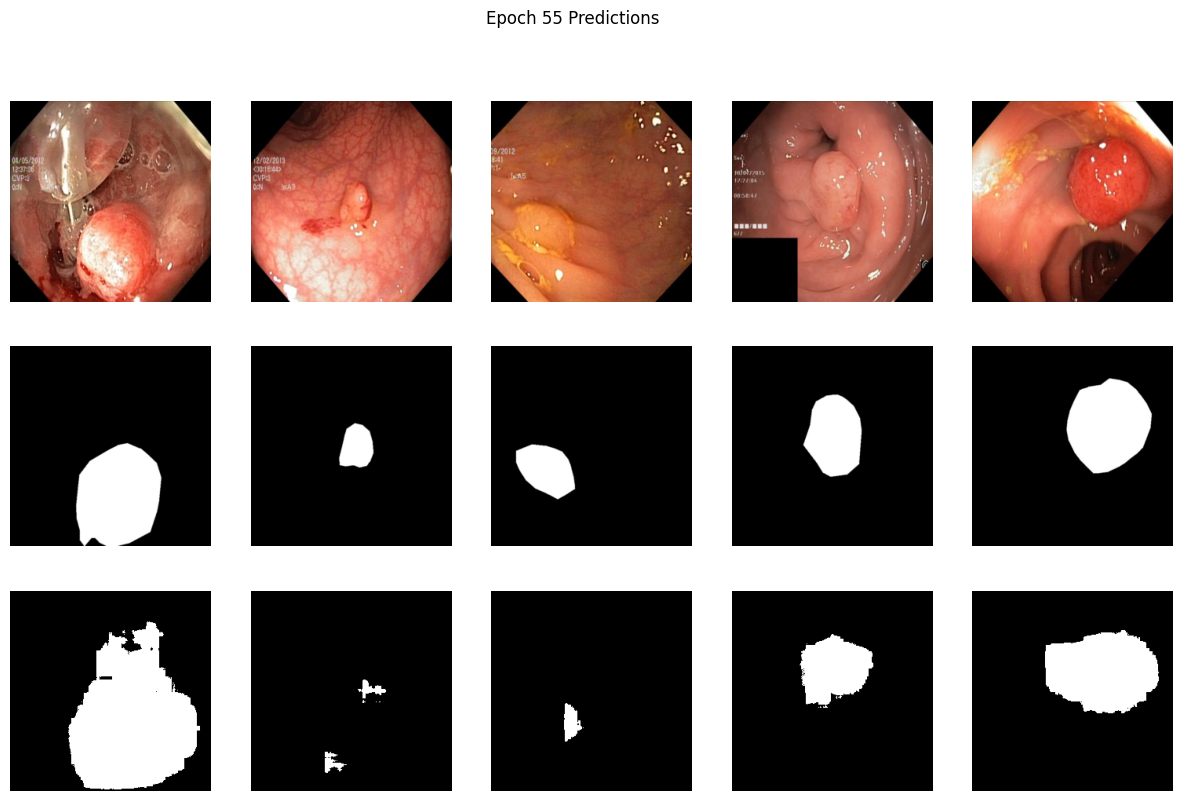

Epoch 56/2000 | Train Loss: 0.8268 | Val Loss: 0.6481 | IoU: 0.5251
Epoch 57/2000 | Train Loss: 0.8183 | Val Loss: 0.6077 | IoU: 0.5491
Epoch 58/2000 | Train Loss: 0.7957 | Val Loss: 0.6120 | IoU: 0.5535
Epoch 59/2000 | Train Loss: 0.7938 | Val Loss: 0.6603 | IoU: 0.5149
Epoch 60/2000 | Train Loss: 0.8019 | Val Loss: 0.6573 | IoU: 0.5080


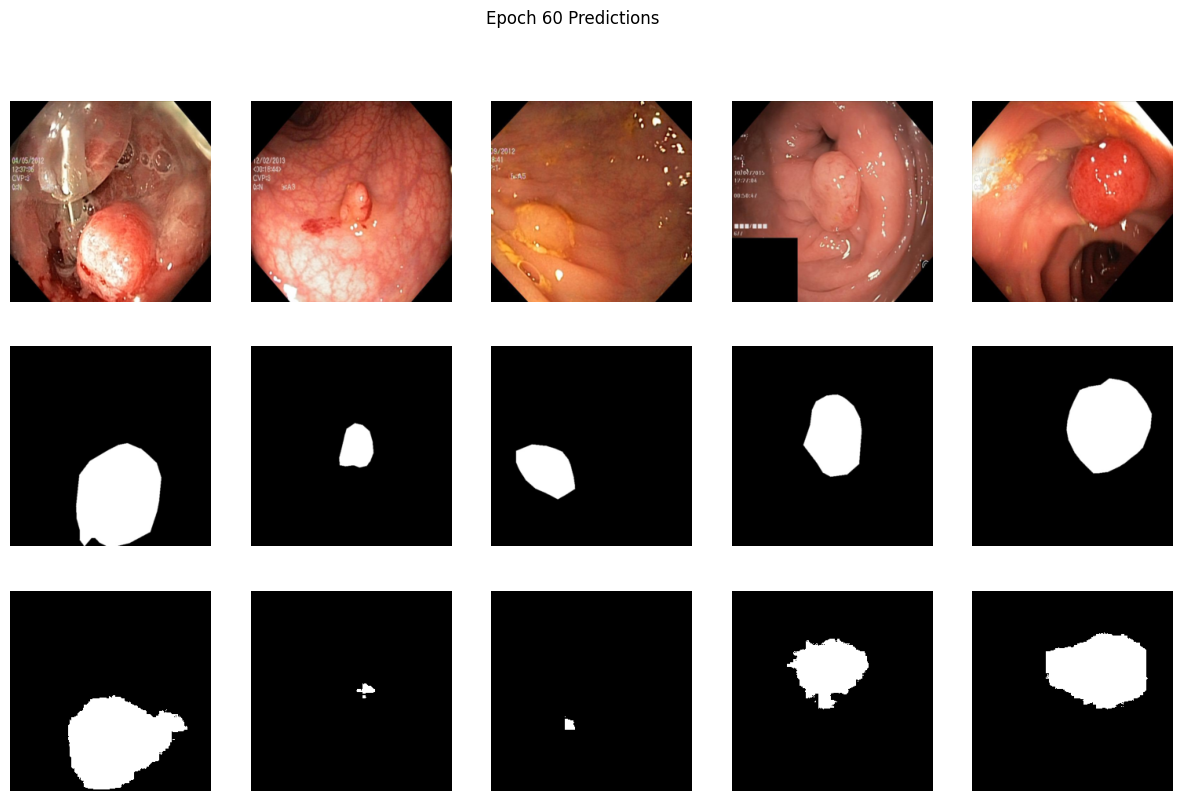

Epoch 61/2000 | Train Loss: 0.7902 | Val Loss: 0.7157 | IoU: 0.4965
Epoch 62/2000 | Train Loss: 0.7925 | Val Loss: 0.5690 | IoU: 0.5779
Saved best model at epoch 62
Epoch 63/2000 | Train Loss: 0.7708 | Val Loss: 0.5790 | IoU: 0.5606
Epoch 64/2000 | Train Loss: 0.7876 | Val Loss: 0.6331 | IoU: 0.5420
Epoch 65/2000 | Train Loss: 0.7761 | Val Loss: 0.6845 | IoU: 0.5161


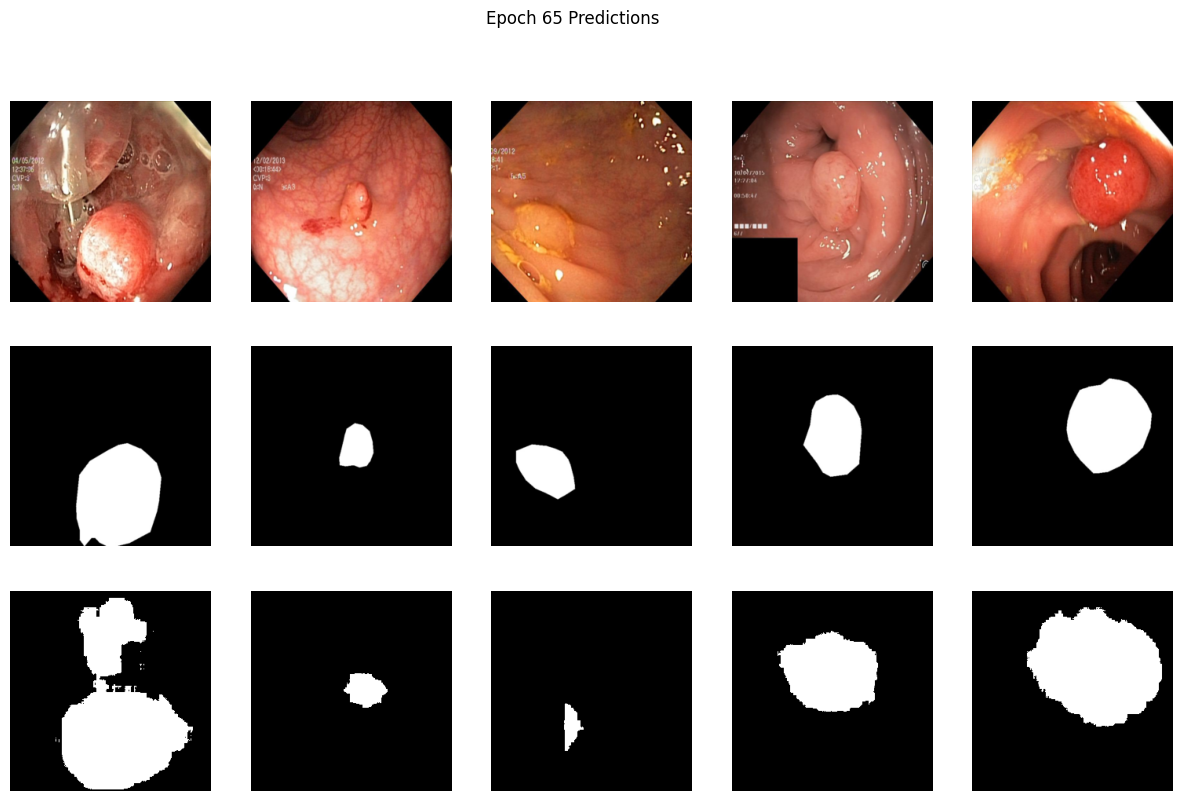

Epoch 66/2000 | Train Loss: 0.7846 | Val Loss: 0.5924 | IoU: 0.5534
Epoch 67/2000 | Train Loss: 0.7881 | Val Loss: 0.5985 | IoU: 0.5554
Epoch 68/2000 | Train Loss: 0.7642 | Val Loss: 0.6088 | IoU: 0.5578
Epoch 69/2000 | Train Loss: 0.7544 | Val Loss: 0.6031 | IoU: 0.5542
Epoch 70/2000 | Train Loss: 0.7695 | Val Loss: 0.6579 | IoU: 0.5082


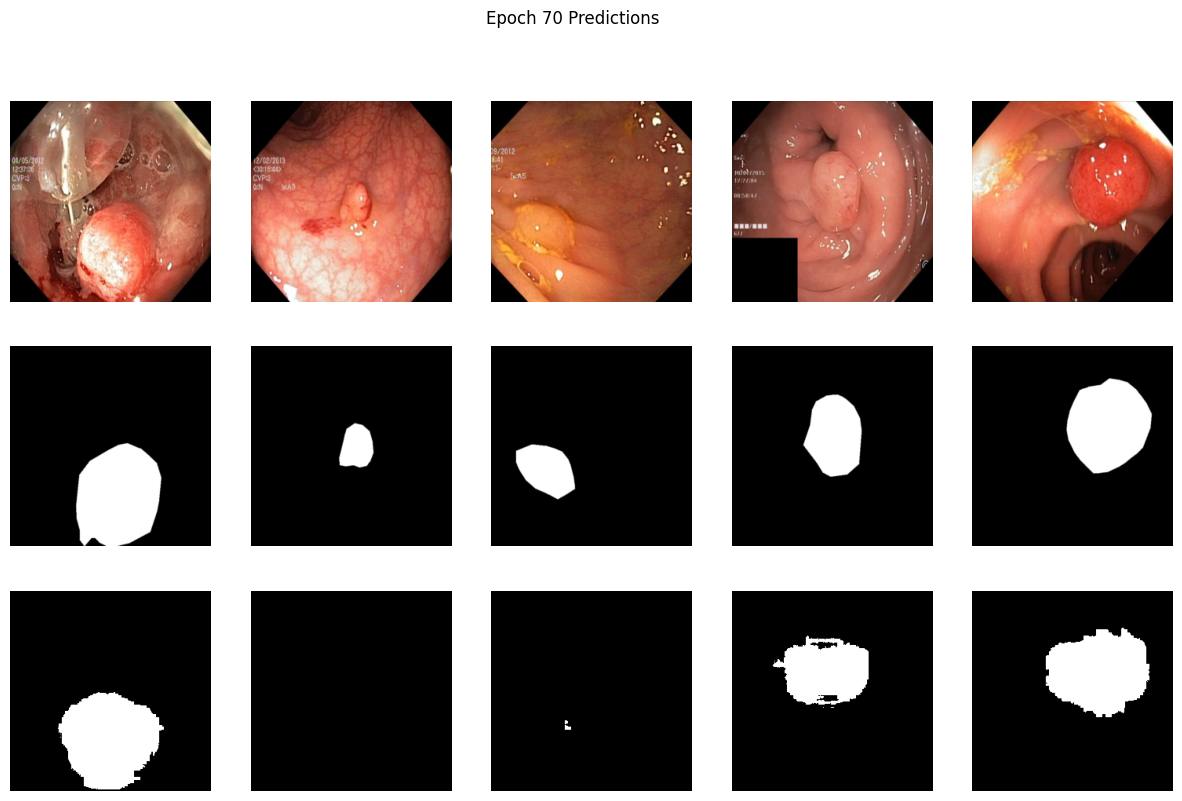

Epoch 71/2000 | Train Loss: 0.7628 | Val Loss: 0.6104 | IoU: 0.5456
Epoch 72/2000 | Train Loss: 0.7467 | Val Loss: 0.5415 | IoU: 0.5970
Saved best model at epoch 72
Epoch 73/2000 | Train Loss: 0.7535 | Val Loss: 0.5819 | IoU: 0.5611
Epoch 74/2000 | Train Loss: 0.7636 | Val Loss: 0.6077 | IoU: 0.5483
Epoch 75/2000 | Train Loss: 0.7437 | Val Loss: 0.6204 | IoU: 0.5444


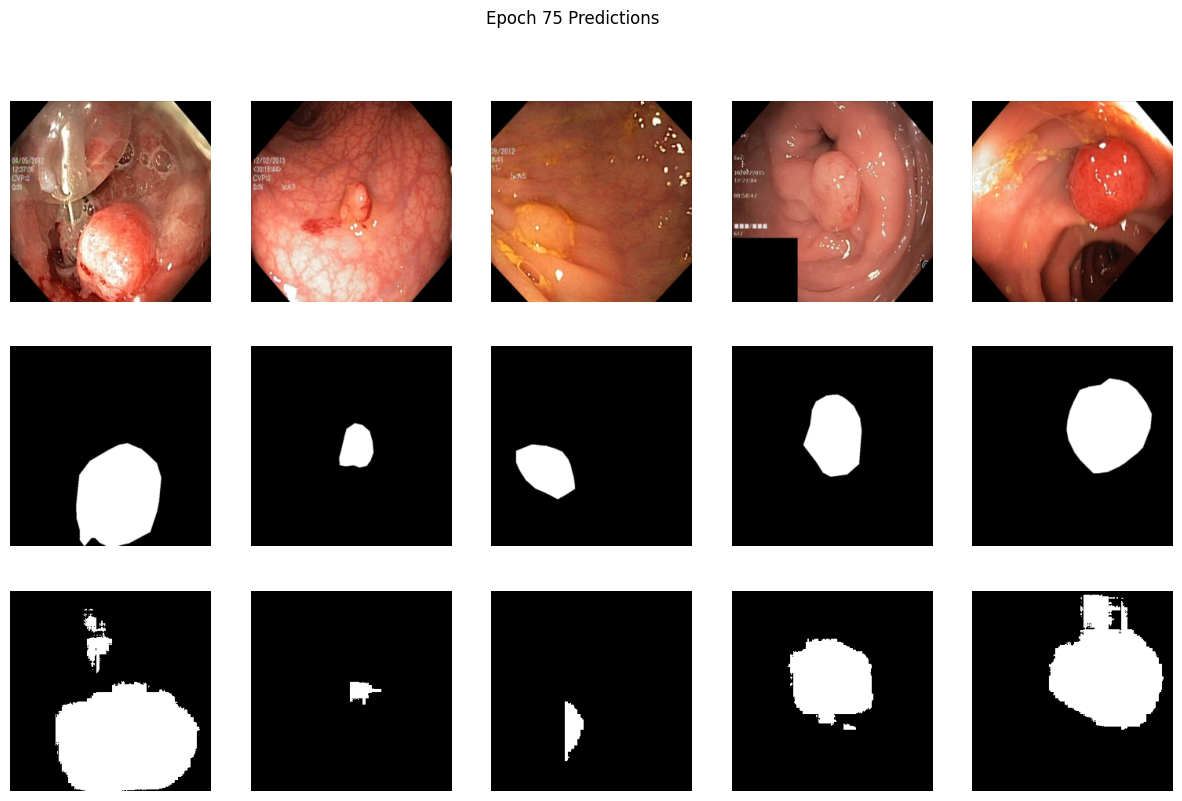

Epoch 76/2000 | Train Loss: 0.7565 | Val Loss: 0.5791 | IoU: 0.5625
Epoch 77/2000 | Train Loss: 0.7327 | Val Loss: 0.6190 | IoU: 0.5401
Epoch 78/2000 | Train Loss: 0.7327 | Val Loss: 0.5775 | IoU: 0.5617
Epoch 79/2000 | Train Loss: 0.7342 | Val Loss: 0.5712 | IoU: 0.5684
Epoch 80/2000 | Train Loss: 0.7175 | Val Loss: 0.5527 | IoU: 0.5785


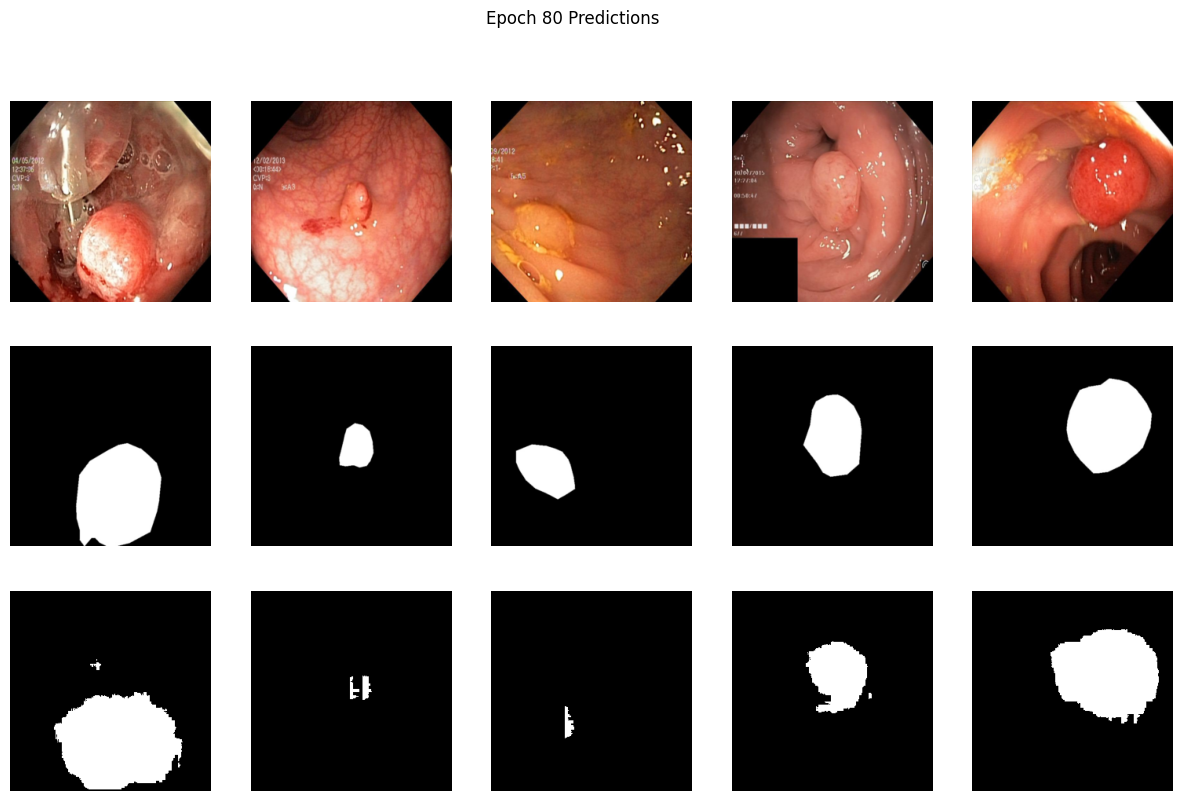

Epoch 81/2000 | Train Loss: 0.7287 | Val Loss: 0.5674 | IoU: 0.5828
Epoch 82/2000 | Train Loss: 0.7145 | Val Loss: 0.5418 | IoU: 0.5897
Epoch 83/2000 | Train Loss: 0.7181 | Val Loss: 0.5662 | IoU: 0.5665
Epoch 84/2000 | Train Loss: 0.7151 | Val Loss: 0.5362 | IoU: 0.5869
Saved best model at epoch 84
Epoch 85/2000 | Train Loss: 0.7115 | Val Loss: 0.7727 | IoU: 0.4145


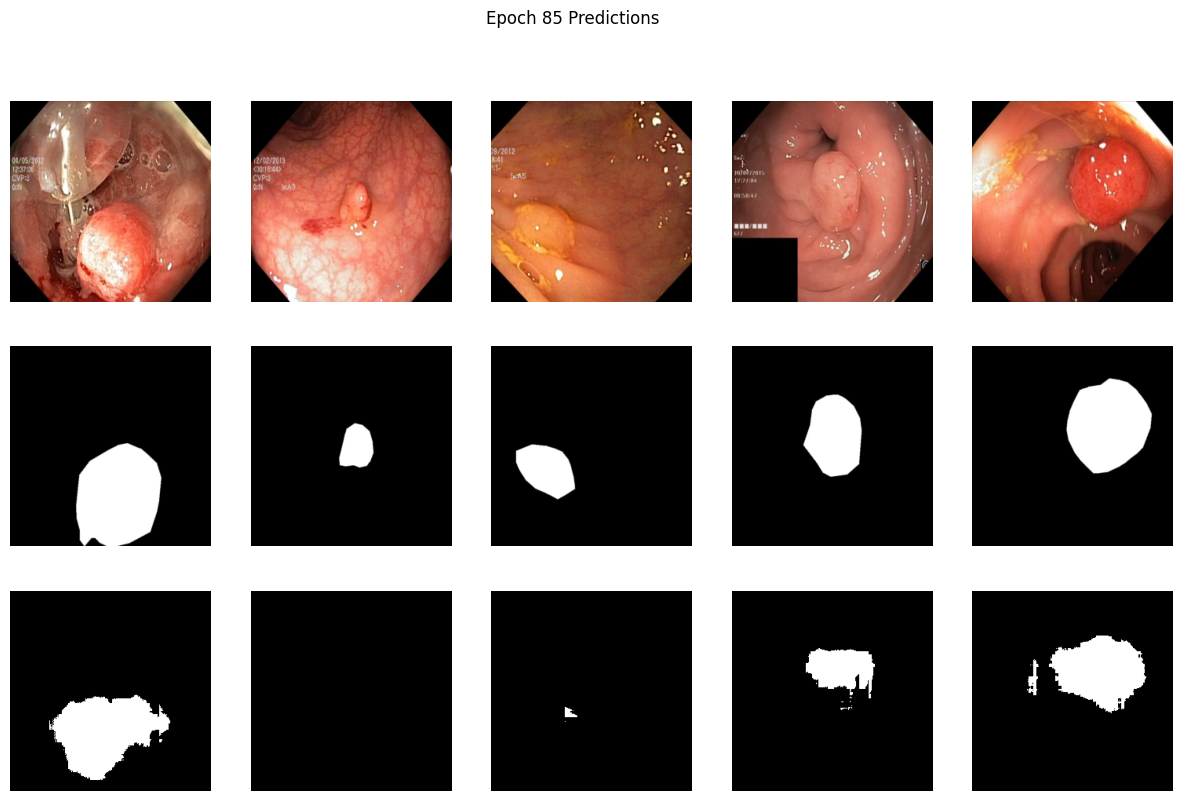

Epoch 86/2000 | Train Loss: 0.7208 | Val Loss: 0.6094 | IoU: 0.5502
Epoch 87/2000 | Train Loss: 0.7057 | Val Loss: 0.5879 | IoU: 0.5543
Epoch 88/2000 | Train Loss: 0.6979 | Val Loss: 0.5499 | IoU: 0.5881
Epoch 89/2000 | Train Loss: 0.7066 | Val Loss: 0.5859 | IoU: 0.5628
Epoch 90/2000 | Train Loss: 0.6874 | Val Loss: 0.5646 | IoU: 0.5741


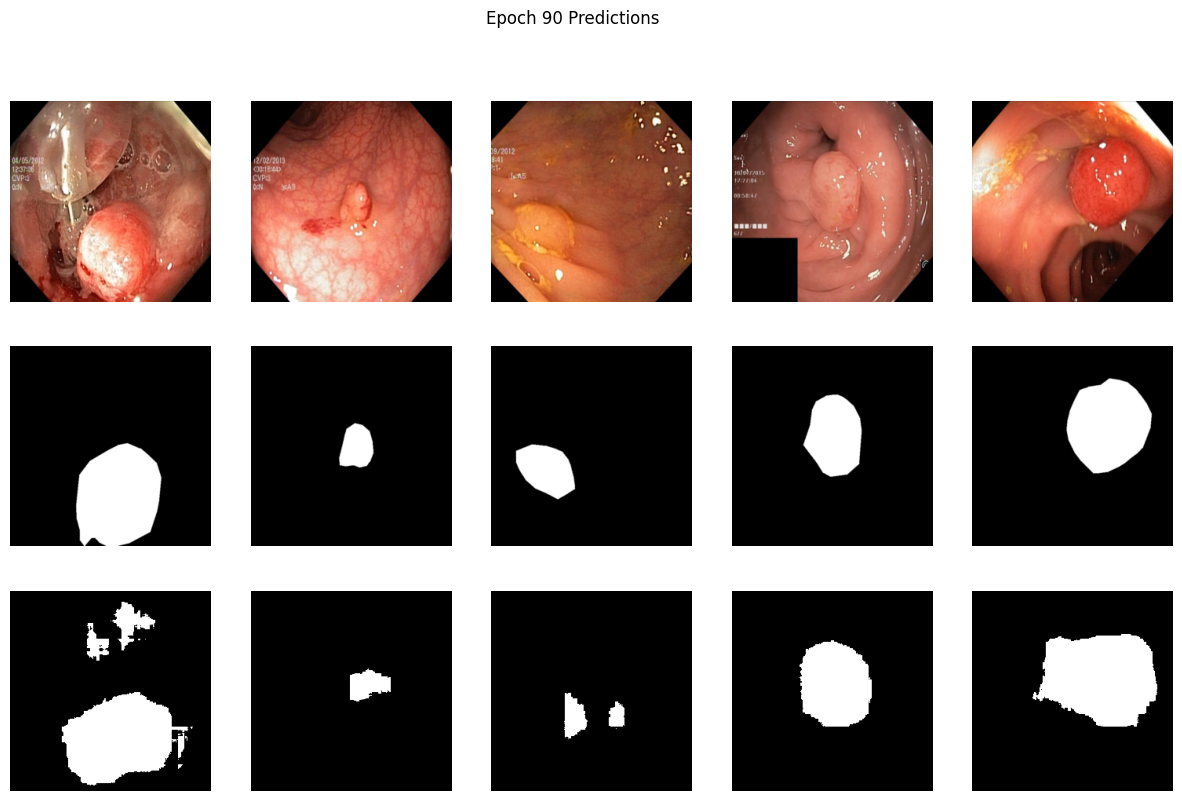

Epoch 91/2000 | Train Loss: 0.7010 | Val Loss: 0.5506 | IoU: 0.5839
Epoch 92/2000 | Train Loss: 0.6918 | Val Loss: 0.5816 | IoU: 0.5533
Epoch 93/2000 | Train Loss: 0.7031 | Val Loss: 0.5927 | IoU: 0.5569


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from torchvision import transforms

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    dice = dice_loss(pred, target)
    bce = bce_loss(pred, target)
    return bce + dice, bce, dice

# IoU calculation
def iou_score(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).int().flatten()
    target = target.int().flatten()
    return (pred & target).sum().float() / ((pred | target).sum().float() + 1e-6)

# Ensure images are resized to 256x256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean/std for your dataset
])

# Define model
model = AttentionUNet(in_channels=3, out_channels=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

checkpoint_path = "/content/drive/MyDrive/Kvasir-SEG/_att_unet_best_model.pth"


def train_or_eval(model, dataloader, criterion, optimizer=None, train=True):
    model.train() if train else model.eval()
    total_loss, total_bce, total_dice, total_iou = 0, 0, 0, 0

    with torch.set_grad_enabled(train):
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).float()
            outputs = model(images)
            loss, bce, dice = criterion(outputs, masks)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            total_bce += bce.item()
            total_dice += dice.item()
            total_iou += iou_score(outputs.detach(), masks).item()

    return (total_loss / len(dataloader), total_bce / len(dataloader),
            total_dice / len(dataloader), total_iou / len(dataloader))

def visualize_predictions(loader, title):
    model.eval()
    with torch.no_grad():
        inputs, targets = next(iter(loader))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = (torch.sigmoid(model(inputs)) > 0.5).float()

        fig, axes = plt.subplots(3, 5, figsize=(15, 9))
        for i in range(5):
            img = inputs[i].cpu().permute(1, 2, 0) if inputs.shape[1] == 3 else inputs[i, 0].cpu()
            axes[0, i].imshow(img, cmap='gray' if inputs.shape[1] == 1 else None)
            axes[1, i].imshow(targets[i].cpu().squeeze(), cmap='gray')
            axes[2, i].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            for ax in axes[:, i]: ax.axis("off")
        plt.suptitle(title)
        plt.show()

# Training loop
# Load best model if available
start_epoch = 0
try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_val_loss = checkpoint.get('val_loss', float("inf"))
    start_epoch = checkpoint.get('epoch', 0)  # Retrieve last trained epoch
    print(f"Loaded best model with val_loss: {best_val_loss:.4f} | Resuming from epoch {start_epoch+1}")
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")
    best_val_loss = float("inf")

# Training loop
num_epochs = 2000  # Total epochs
for epoch in range(start_epoch, num_epochs):  # Resume from last epoch
    train_loss, train_bce, train_dice, train_iou = train_or_eval(model, train_loader, combined_loss, optimizer, train=True)
    val_loss, val_bce, val_dice, val_iou = train_or_eval(model, test_loader, combined_loss, train=False)

    current_epoch = epoch + 1  # Current epoch considering previous training
    print(f"Epoch {current_epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'model_state_dict': model.state_dict(), 'val_loss': val_loss, 'epoch': epoch}, checkpoint_path)
        print(f"Saved best model at epoch {current_epoch}")

    if (current_epoch) % 5 == 0:
        visualize_predictions(test_loader, title=f"Epoch {current_epoch} Predictions")
